# Orientation/Direction Tuning
- Compute tuning curves.
- Determine orientation/direction selectivity of cells using permutation test (Ecker et al., 2014, Baden et al., 2016).

In [16]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import percentileofscore

%matplotlib inline

## Load calcium traces

In [42]:
#! bash downloadCalciumTraces.sh

f_rawtrace = open("data/trace_raw.pkl","rb")
RawTrace = pickle.load(f_rawtrace)
f_rawtrace.close()

f_trace = open("data/trace.pkl", "rb")
Trace = pickle.load(f_trace)
f_trace.close()

f_spike = open("data/spike.pkl", "rb")
Spike = pickle.load(f_spike)
f_spike.close()

f_stim_lab = open("data/stimulus_label.pkl", "rb")
StimulusLabel = pickle.load(f_stim_lab)
f_stim_lab.close()

In [65]:
cell_info = pd.read_csv("data/cell_functional_info.csv")

seg_id_list = np.array(cell_info["segment_id"])
scan_list = np.array(cell_info["scan"])
n_cells = seg_id_list.shape[0]

cell_info

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,1,1.399790,0.0093,0.360205,0.9048
1,648518346349537860,1,1.768346,0.0000,0.439699,0.6045
2,648518346349538440,1,1.375106,0.0027,0.263231,0.9977
3,648518346349538527,1,1.021334,0.0285,0.972555,0.9738
4,648518346349538209,1,1.863632,0.0000,0.100173,0.9697
...,...,...,...,...,...,...
107,648518346349537741,5,1.266736,0.0591,0.528219,0.9734
108,648518346349537901,5,1.163586,0.1107,1.162096,0.1381
109,648518346349538001,5,1.352991,0.0468,1.350374,0.0465
110,648518346349538251,5,1.436740,0.0149,1.399342,0.0315


## Functions

In [58]:
def dsi(amp_arr):
    
    u, s, vh = np.linalg.svd(amp_arr, full_matrices=False)
    
    resp_dir = -vh[0,:]
    resp_dir = resp_dir.reshape((16,1))
    
    angles = np.linspace(0, 2*np.pi, 17)[:-1]
    vec = np.zeros((1,16), dtype="complex")
    for i in range(16):
        vec[0,i] = np.exp(complex(0,angles[i]))
    K = vec@resp_dir
    
    return np.abs(K)[0]


def osi(amp_arr):
    
    u, s, vh = np.linalg.svd(amp_arr, full_matrices=False)
    
    resp_dir = -vh[0,:]
    resp_dir = resp_dir.reshape((16,1))
    
    angles = np.linspace(0, 4*np.pi, 17)[:-1]
    vec = np.zeros((1,16), dtype="complex")
    for i in range(16):
        vec[0,i] = np.exp(complex(0,angles[i]))
    K = vec@resp_dir
    
    return np.abs(K)[0]


def shuffle_amparr(amp_arr):
    
    amp_arr_copy = np.copy(amp_arr)
    for i in range(amp_arr.shape[0]):
        
        tmp = amp_arr_copy[i,:]
        np.random.shuffle(tmp)
        
    return amp_arr_copy


def permutation_test(amp_arr, n_shuff, mode="dsi"):
    
    si_shuffled = np.zeros(n_shuff)
    
    if mode=="dsi":
        
        si_true = dsi(amp_arr)
        for t in range(n_shuff):

            amp_arr_shuffled = shuffle_amparr(amp_arr)
            si_shuffled[t] = dsi(amp_arr_shuffled)
        
    elif mode=="osi":
        
        si_true = osi(amp_arr)
        for t in range(n_shuff):

            amp_arr_shuffled = shuffle_amparr(amp_arr)
            si_shuffled[t] = osi(amp_arr_shuffled)
            
    p = percentileofscore(si_shuffled, si_true)
    p = 1-p/100
        
    return si_shuffled, p

In [66]:
def get_peakamp_tdarray(trace, condition):
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    tdarray = np.zeros((30,16))
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)
        
        offset = 0
        for j in range(len(section_list)):
            
            if len(section_list)!=30:
                offset = 30-len(section_list)
                
            s = section_list[j] 
            trace_sect = trace[s[0]:s[1]]
            
            max_idx = np.argmax(trace_sect)
            max_val = trace_sect[max_idx]
            if (max_idx==0):
                tdarray[j+offset,i] = 0      
            elif (max_idx==trace_sect.shape[0]-1):
                trace_post = trace[s[1]:s[1]+15]
                tdarray[j+offset,i] = np.max(trace_post)
            elif trace_sect[0]>0.5*max_val:
                tdarray[j+offset,i] = 0
            else:
                tdarray[j+offset,i] = max_val
    
    return tdarray


def decompose_tdarray(tdarray):
    
    u, s, vh = np.linalg.svd(tdarray, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    
    return resp_dir, resp_t


def get_tuning_curve(trace, label):
    
    response_array = get_peakamp_tdarray(trace, condition)

In [67]:
# Get sections of particular directions
def get_section(conditions, angle):
    
    if np.isnan(angle):
        valid = np.isnan(conditions).astype("int")
    else:
        valid = (conditions==angle).astype("int")
    
    valid_diff = np.diff(valid)
    valid_diff = valid_diff.reshape((1,-1))
    
    st_idx = np.where(valid_diff==1)[1] + 1
    end_idx = np.where(valid_diff==-1)[1]
    
    if st_idx.shape[0] > end_idx.shape[0]:
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    elif st_idx.shape[0] < end_idx.shape[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
    elif st_idx[0] > end_idx[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    
    section_list = []
    for i in range(st_idx.shape[0]):
        section_list.append((st_idx[i], end_idx[i]+1))
    
    return section_list


def view_trials(trace, condition, show_lines=True):
    
    plt.figure(figsize=(16,16))

    angle_list = np.unique(condition)
    for i in range(16):

        ax = plt.subplot(4,4,i+1)

        angle = angle_list[i]
        section_list = get_section(condition, angle)
    
        if show_lines:
            for s in section_list:
                n = s[1] - s[0]
                plt.plot(np.arange(0,n*0.0674-0.001,0.0674), trace[s[0]:s[1]], linewidth=0.5)

        else:
            n = 15
            trace_all = np.ones((len(section_list),n))*np.nan
            for j in range(len(section_list)):

                s = section_list[j]

                trace_section = trace[s[0]:s[1]]
                trace_all[j,:trace_section.shape[0]] = trace_section

            mean_trace = np.nanmean(trace_all, axis=0)
            std = np.nanstd(trace_all, axis=0)

            t = np.arange(0,n*0.0674-0.001,0.0674)
            ax.plot(t, mean_trace)
            ax.fill_between(t, mean_trace-std, mean_trace, facecolor='blue', alpha=0.3)
            ax.fill_between(t, mean_trace, mean_trace+std, facecolor='blue', alpha=0.3)
        
        plt.ylim([trace.min(), trace.max()])
        plt.title(str(np.round(angle,2)))
        
        if i == 0: 
            plt.xlabel("Time (s)")
            plt.ylabel("Response (a.u.)")
        
    plt.show()

## Tuning curve computation

### Example cell

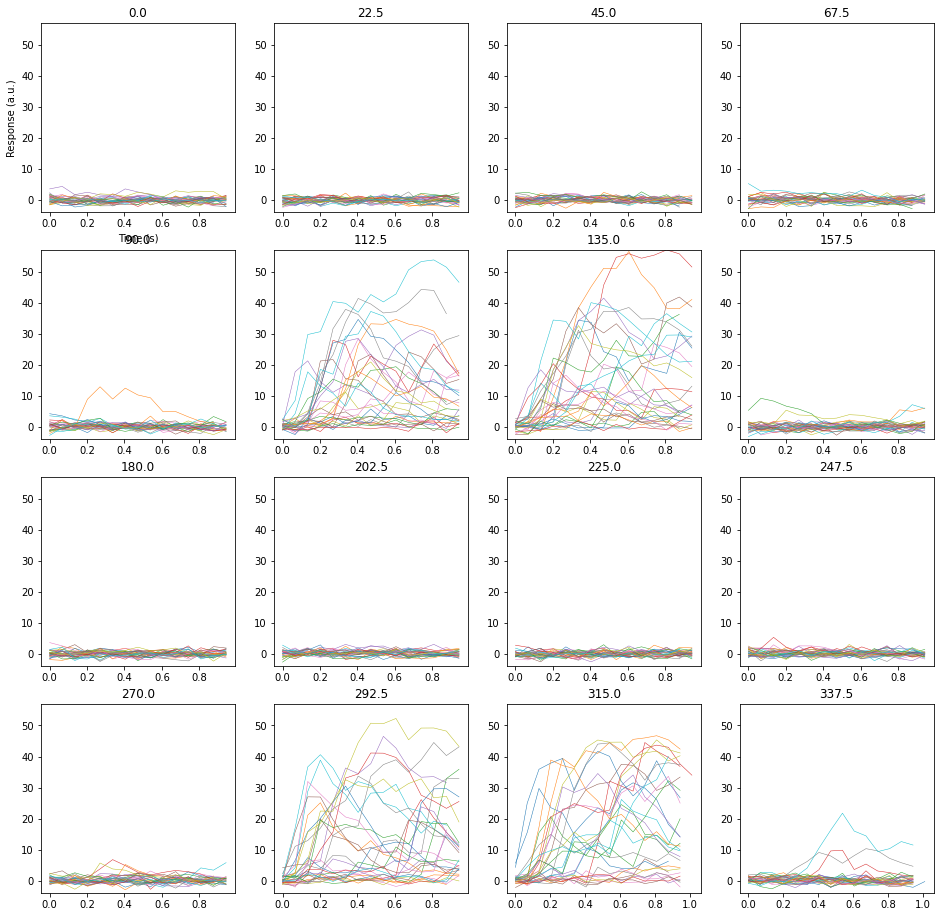

In [54]:
seg_id = 648518346349537961
scan_id = int(scan_list[seg_id_list==seg_id])

trace = RawTrace[seg_id]
stimlab = StimulusLabel["scan{}".format(scan_id)]

view_trials(trace, stimlab)

## Determine orientation/direction selectivity

In [87]:
T = 10000 # Number of iterations for permutation test

dsi_list = np.zeros(n_cells)
osi_list = np.zeros(n_cells)
dsi_pvalue = np.zeros(n_cells)
osi_pvalue = np.zeros(n_cells)
for i in range(n_cells):
    
    seg_id = seg_id_list[i]
    scan_id = int(scan_list[seg_id_list==seg_id])

    trace = Trace[seg_id]
    stimlab = StimulusLabel["scan{}".format(scan_id)]
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    dsi_list[i] = dsi(response_array)
    osi_list[i] = osi(response_array)
    dsi_shuf, dsi_pvalue[i] = permutation_test(response_array, T, "dsi")
    osi_shuf, osi_pvalue[i] = permutation_test(response_array, T, "osi")
    
    if (i+1)%10==0:
        print("{} / {} complete.".format(i+1, n_cells))

10 / 112 complete.
20 / 112 complete.
30 / 112 complete.
40 / 112 complete.
50 / 112 complete.
60 / 112 complete.
70 / 112 complete.
80 / 112 complete.
90 / 112 complete.
100 / 112 complete.
110 / 112 complete.


In [112]:
# Same format as data/cell_functional_info.csv
data = {"segment_id": seg_id_list,
     "scan": scan_list,
     "osi": osi_list, 
     "osi_p": osi_pvalue,
     "dsi": dsi_list,
     "dsi_p": dsi_pvalue}

df = pd.DataFrame(data=data)
df

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,1,1.399790,0.0085,0.360205,0.9077
1,648518346349537860,1,1.791797,0.0000,0.379977,0.7241
2,648518346349538440,1,1.369347,0.0025,0.257158,0.9983
3,648518346349538527,1,1.021334,0.0276,0.972555,0.9746
4,648518346349538209,1,1.863632,0.0000,0.100173,0.9763
...,...,...,...,...,...,...
107,648518346349537741,5,1.266736,0.0568,0.528219,0.9732
108,648518346349537901,5,1.163586,0.1148,1.162096,0.1404
109,648518346349538001,5,1.321359,0.0631,1.324058,0.0638
110,648518346349538251,5,1.436740,0.0139,1.399342,0.0287
